In [ ]:
!nvidia-smi

Fri Dec 20 04:36:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
!pip list | grep torch

torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121


In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("commercial-marine-fish-species").project("commercial-marine-fish-species")
version = project.version(3)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to Commercial-Marine-Fish-Species-3 in yolov11:: 100%|██████████| 9302/9302 [00:01<00:00, 5202.97it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=50 batch=32 imgsz=640 plots=True

/content
100% 5.35M/5.35M [00:00<00:00, 317MB/s]
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/Commercial-Marine-Fish-Species-3/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1734669636.7ea84a3141ee.1900.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					    train_batch4360.jpg  weights
P_curve.png					    train_batch4361.jpg
PR_curve.png					    train_batch4362.jpg


**NOTE:** The results of the completed training saved in `{HOME}/runs/detect/train/`.

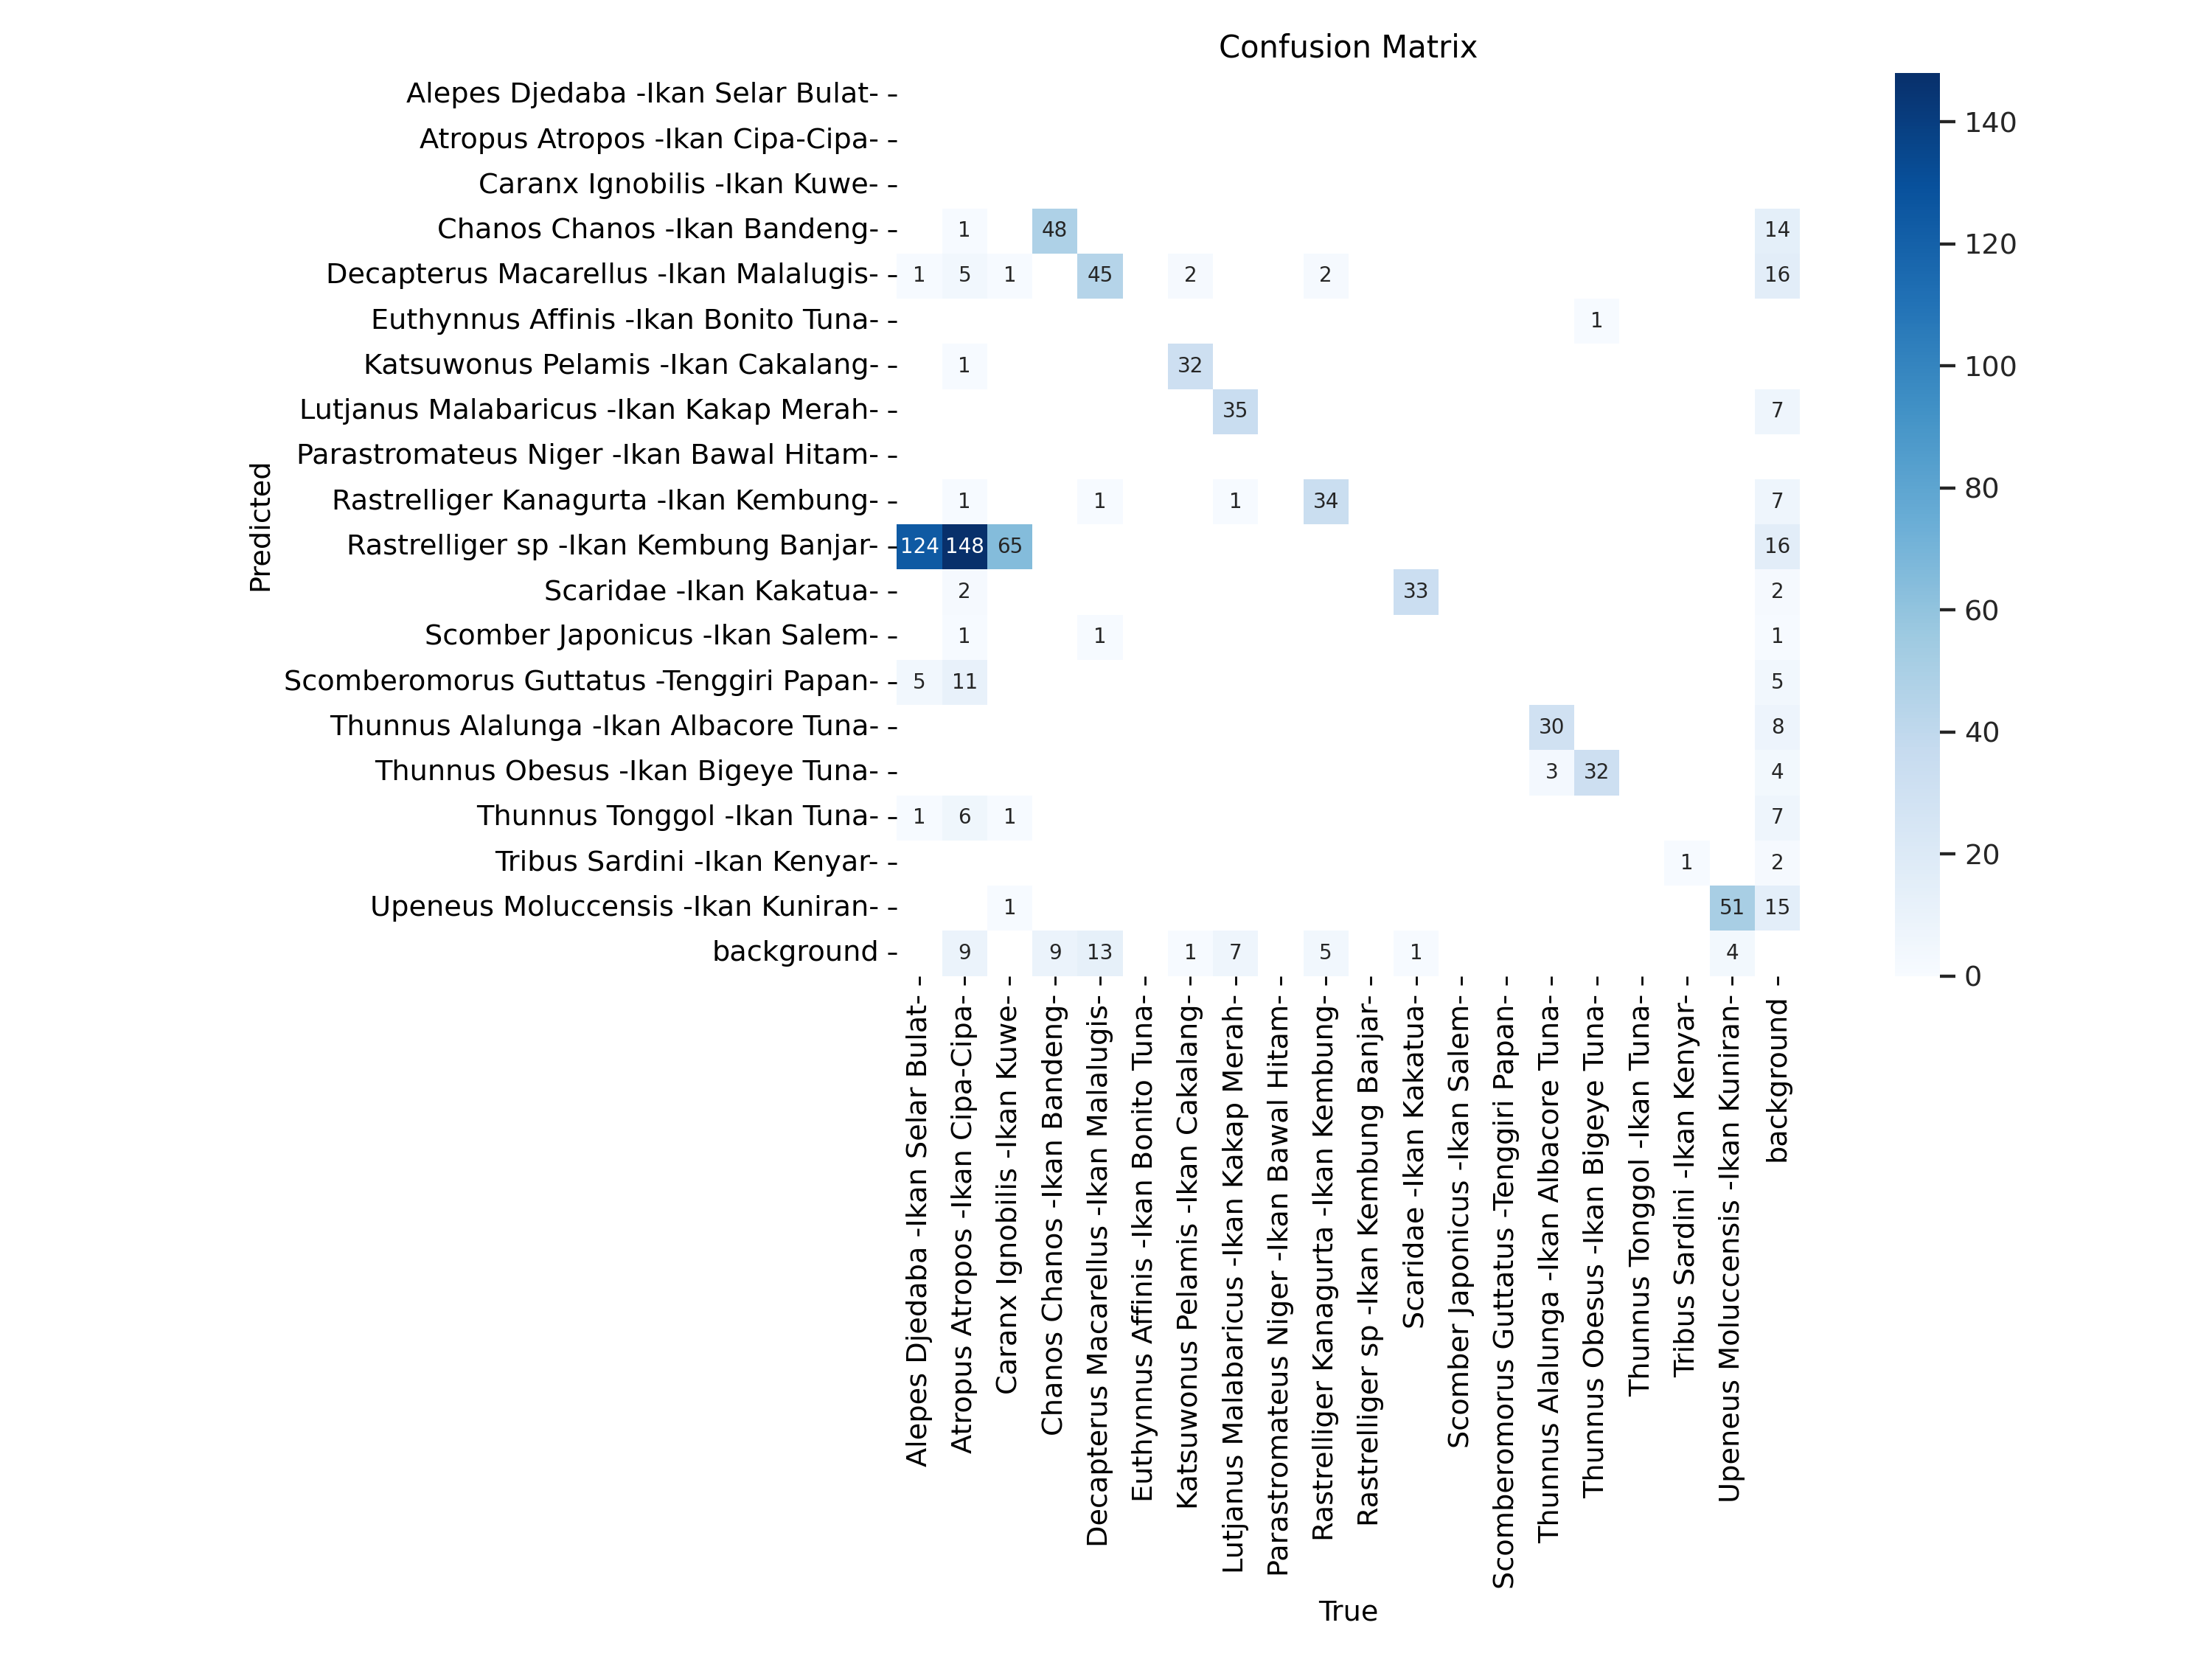

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

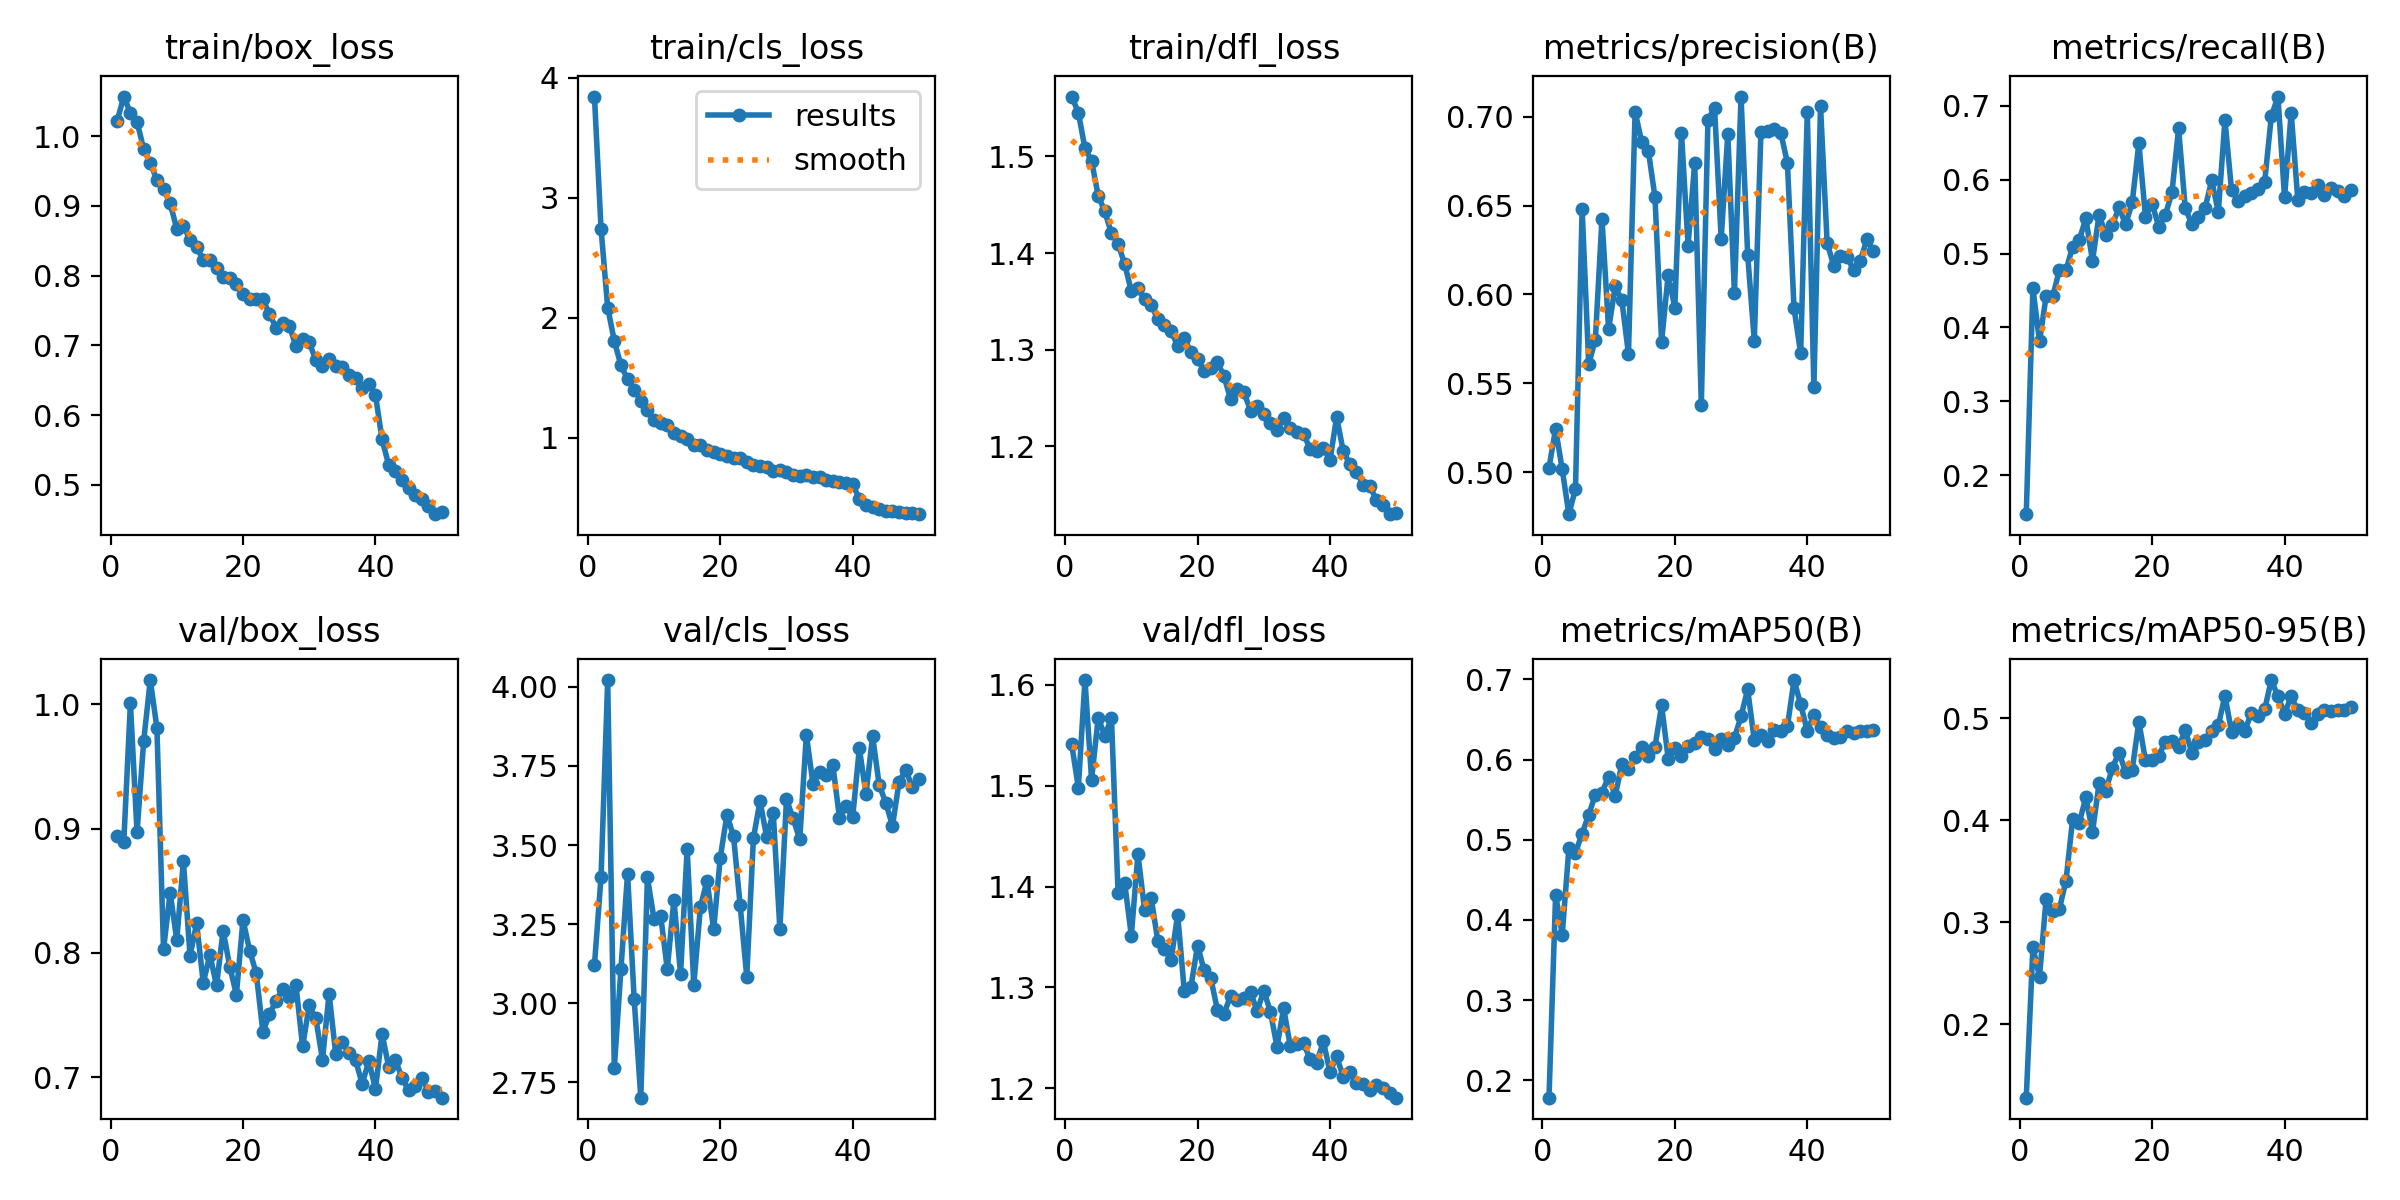

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

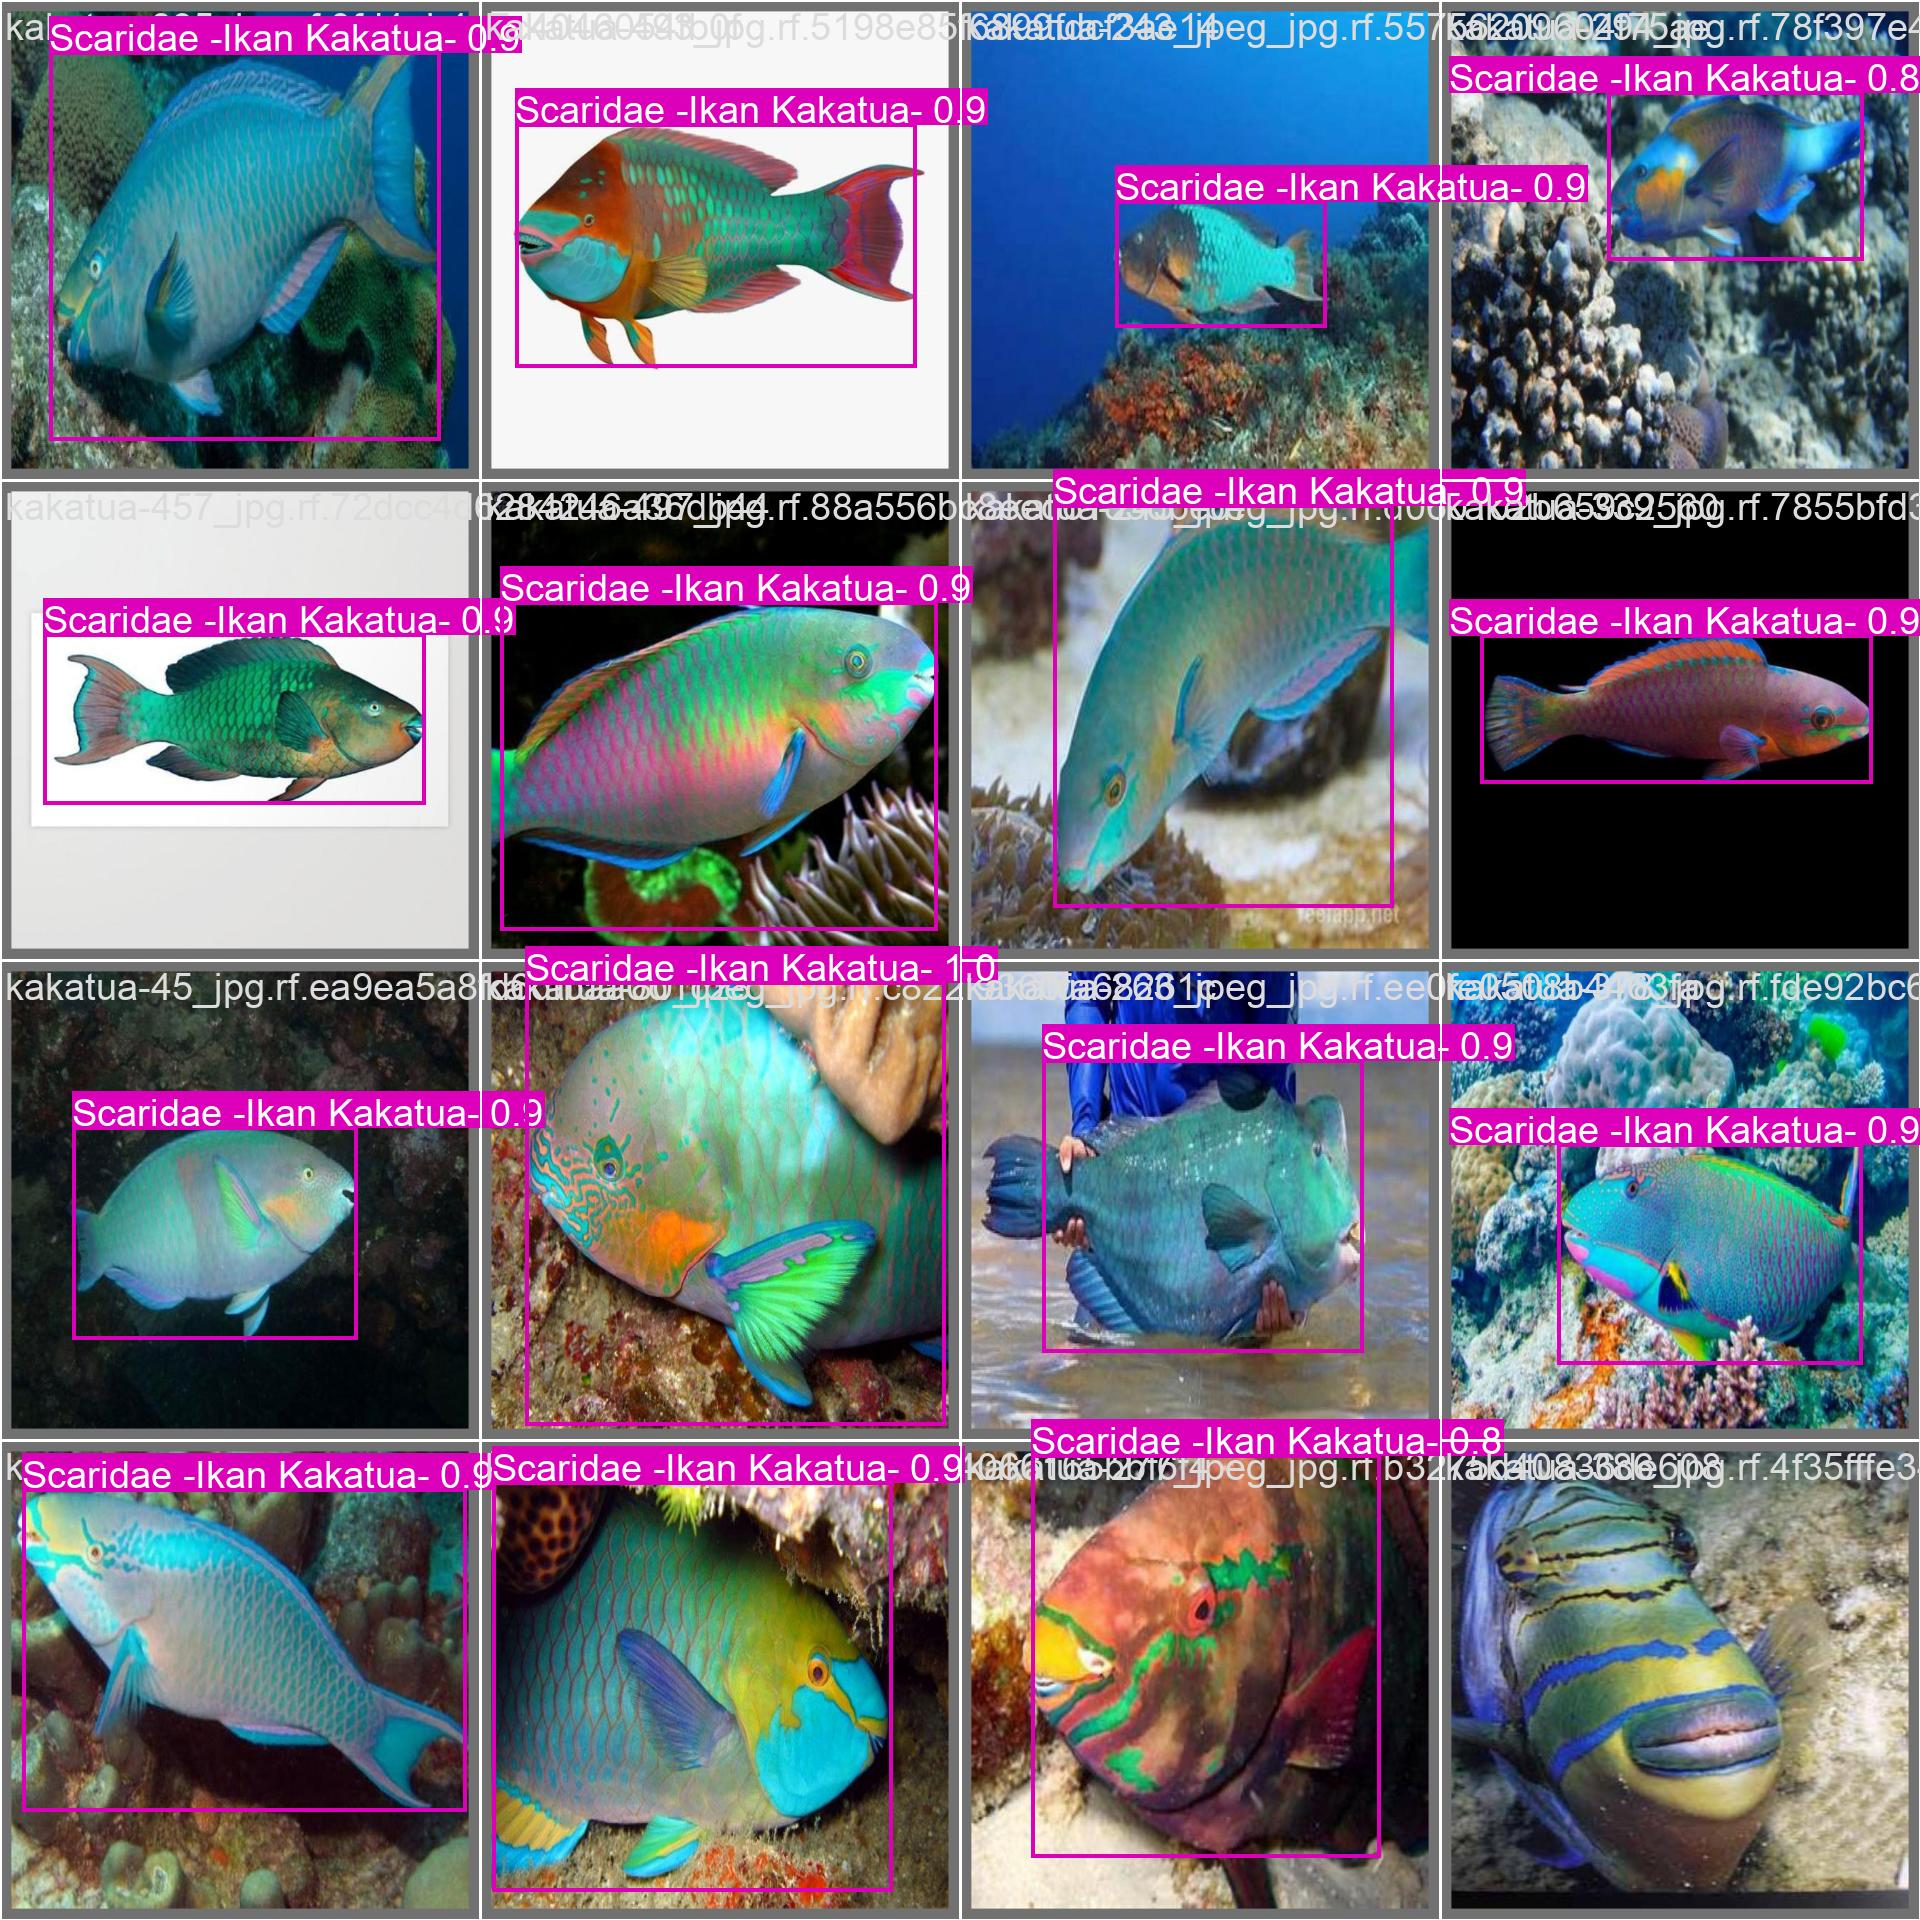

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/datasets/Commercial-Marine-Fish-Species-3/valid/labels.cache... 584 images, 0 backgrounds, 0 corrupt: 100% 584/584 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 42, len(boxes) = 776. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 37/37 [00:07<00:00,  4.76it/s]
                   all        584        776      0.592      0.685      0.699      0.538
Alepes Djedaba -Ikan Selar Bulat-         86        131          0          0          0          0
Atropus Atropos -Ikan Cipa-Cipa-        160        185          0          0          0       

## Deploy model on Roboflow

Finished training the YOLOv11 model, a set of trained weights is ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of the project. Upload the model weights to Roboflow Deploy to use the trained weights on Roboflow infinitely scalable infrastructure.

In [ ]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("commercial-marine-fish-species").project("commercial-marine-fish-species")
version = project.version(3)
version.deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/commercial-marine-fish-species/commercial-marine-fish-species/3
Share your model with the world at: https://universe.roboflow.com/commercial-marine-fish-species/commercial-marine-fish-species/model/3
